# Adversarial Attacks on MNIST with FGSM and PGD attacks

In this notebook, we perform FGSM (targeted and non-targeted) and PGD attacks on the MNIST dataset using the Resnet18 model and build models to defend against these attacks using the Adversarial Training mechanism.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet_2 import *

import pickle

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01

<a name='name'></a>
### Preparing train and test data and building Resnet model

In [3]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# MNIST dataset
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2)

# Classes
classes = tuple(str(i) for i in range(10))  # Digits 0 to 9

# Model
print('==> Building model..')
# Use ResNet18 with 10 output classes for MNIST
net = ResNet18()
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [ ]:
def train(epoch, net):
    
    '''
    this function train net on training dataset
    '''

    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_accuracies = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx)
    return train_loss/len(trainloader)

In [4]:
def test(epoch, net):

    '''
    This function evaluate net on test dataset
    '''

    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_accuracies = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss/len(testloader)

In [ ]:
train_losses=[]
test_losses=[]
epochs=3

for epoch in range(0,epochs):
    train_losses.append(train(epoch, net))
    test_losses.append(test(epoch, net))
    scheduler.step()

In [ ]:
print('Accuracy of the network on the test images: %d %%' % (acc))

In [ ]:
epochs=3
plt.plot(np.arange(1,epochs+1),train_losses, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses, label='test losses')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [ ]:
accuracies = []
epochs = 3

for epoch in range(0, epochs):
    accuracy = acc  # Assuming 'acc' is a global variable in your existing code
    accuracies.append(accuracy)

    scheduler.step()

In [ ]:
plt.plot(range(1, epochs + 1), accuracies, label='Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [5]:
imgloader = torch.utils.data.DataLoader(
    testset, batch_size=30, shuffle=False, num_workers=2)
dataiter = iter(imgloader)
org_images, org_labels = next(dataiter)

In [6]:
org_labels = org_labels.to(device)
org_images = org_images.to(device)
print(org_images.shape)
outputs= net(org_images)
output=outputs.to(device)
print(outputs.shape)
_, predicted = torch.max(outputs.data, 1)

torch.Size([30, 1, 28, 28])
torch.Size([30, 10])


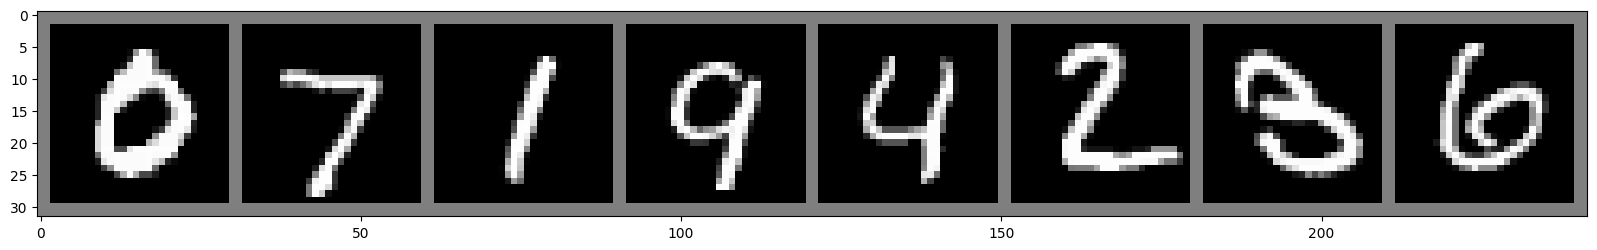

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


samples = []
samples_labels = []
samples_pred = []
selected = [3,0,5,16,4,1,18,11]

for i in selected:
  samples.append(org_images[i])
  samples_labels.append(org_labels[i])
  samples_pred.append(outputs[i])
samples = torch.stack(samples)
samples_labels = torch.stack(samples_labels)
samples_pred = torch.stack(samples_pred)
imshow(torchvision.utils.make_grid(samples.cpu()))

In [ ]:
def FGSM(net, x, y, eps):
        '''
        inputs:
            net: the network through which we pass the inputs
            x: the original example which we aim to perturb to make an adversarial example
            y: the true label of x
            eps: perturbation budget

        outputs:
            x_adv : the adversarial example constructed from x
            h_adv: output of the last softmax layer when applying net on x_adv 
            y_adv: predicted label for x_adv
            pert: perturbation applied to x (x_adv - x)
        '''

        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert

In [ ]:
print()
print('from left to right: (1/eps) perturbation, original image, adversarial example')
print()
for i in selected:
    eps=1/255
    while True:
        x_adv, h_adv, y_adv, pert=FGSM(net, org_images[i].unsqueeze_(0),org_labels[i].unsqueeze_(0),eps)
        if y_adv.item()==org_labels[i].item():
            eps=eps+(1/255)
        else:
            break
    print("true label:", org_labels[i].item(), "adversary label:", y_adv.item())
    triple=[]
    with torch.no_grad():
        triple.append((1/eps)*pert.detach().clone().squeeze_(0))
        triple.append(org_images[i])
        triple.append(x_adv.detach().clone().squeeze_(0))
        triple=torch.stack(triple)
        grid = torchvision.utils.make_grid(triple.cpu()/2+0.5)
        plt.figure(figsize=(10,10))
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.show()

In [ ]:
print('==> Building new model..')
net_adv = ResNet18()
net_adv = net_adv.to(device)
if device == 'cuda':
    net_adv = torch.nn.DataParallel(net_adv)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_adv = optim.SGD(net_adv.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_adv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv, T_max=200)

In [ ]:
def train_adv(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = Variable(inputs.data, requires_grad=True)
        h_ = net(inputs_)

        cost = criterion(h_, targets)

        net.zero_grad()
        cost.backward()

        pert= eps*inputs_.grad.detach().sign()
        x_adv = inputs_ + pert

        optimizer_adv.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx)
    return train_loss/len(trainloader)

In [ ]:
train_losses_adv=[]
test_losses_adv=[]
epochs=3

for epoch in range(0,epochs):
    train_losses_adv.append(train_adv(epoch, net_adv))
    test_losses_adv.append(test(epoch, net_adv))
    scheduler_adv.step()

In [ ]:
print('Accuracy of the network on unperturbed test images: %d %%' % (acc))

In [ ]:
plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train - adversary')
plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test - adversary')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [ ]:
def test_adv(net, net_adv, eps):
    accuracy=0
    net.train()
    net_adv.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, h_adv, y_adv, pert = FGSM (net, inputs, targets, eps)
            
        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
for eps in [4/255, 8/255, 12/255]:
    accuracy=test_adv(net, net_adv, eps)
    print("epsilon:", eps, "accuracy:", accuracy)

In [ ]:
def FGSM_with_AdvancedGaussianDefense(net, x, y, eps, sigma=0.2, alpha=0.2):
    '''
    inputs:
        net: the network through which we pass the inputs
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        eps: perturbation budget
        sigma: standard deviation of the Gaussian noise
        alpha: spatially varying factor for Gaussian noise

    outputs:
        x_adv : the adversarial example constructed from x with advanced Gaussian defense
        h_adv: output of the last softmax layer when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''

    x_ = torch.autograd.Variable(x.data, requires_grad=True)
    
    # Forward pass
    h_ = net(x_)
    
    # Calculate the cross-entropy loss
    criterion = torch.nn.CrossEntropyLoss()
    cost = criterion(h_, y)
    
    # Backward pass
    net.zero_grad()
    cost.backward()
    
    # Perturbation using FGSM
    pert = eps * x_.grad.detach().sign()
    
    # Create a spatially varying defense factor
    defense_factor = alpha * torch.randn_like(x_)
    
    # Apply spatially varying Gaussian defense to the perturbation
    pert = pert + defense_factor * sigma
    
    # Create the adversarial example
    x_adv = x_ + pert
    
    # Forward pass on the adversarial example
    h_adv = net(x_adv)
    
    # Get the predicted label for the adversarial example
    _, y_adv = torch.max(h_adv.data, 1)
    
    return x_adv, h_adv, y_adv, pert

In [ ]:
def train_adv_d(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    sigma = 0.2
    eps = 8 / 255
    criterion = torch.nn.CrossEntropyLoss()

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = torch.autograd.Variable(inputs.data, requires_grad=True)
        h_ = net(inputs_)

        cost = criterion(h_, targets)

        net.zero_grad()
        cost.backward()

        # Perturbation using FGSM
        pert = eps * inputs_.grad.detach().sign()
        
        # Apply Gaussian defense to the perturbation
        pert = pert + torch.randn_like(inputs_) * sigma

        x_adv = inputs_ + pert

        optimizer_adv.zero_grad()

        # Forward pass on the adversarial example
        outputs = net(x_adv)

        # You may want to apply Gaussian defense to the adversarial example here
        pert_adv = torch.randn_like(x_adv) * sigma
        x_adv = x_adv + pert_adv

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx)
    
    return train_loss / len(trainloader)

In [ ]:
train_losses_adv_g = []
test_losses_adv_g = []
epochs = 3

for epoch in range(epochs):
    train_losses_adv_g.append(train_adv_d(epoch, net_adv))
    test_losses_adv_g.append(test(epoch, net_adv))
    scheduler_adv.step()

In [ ]:
print('Accuracy of the network on unperturbed test images: %d %%' % (acc))

In [ ]:
plt.plot(np.arange(1,epochs+1),train_losses_adv_g, label='train - adversary')
plt.plot(np.arange(1,epochs+1), test_losses_adv_g, label='test - adversary')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [ ]:
def test_adv_d(net, net_adv, eps, sigma=0.2):
    accuracy = 0
    net.train()
    net_adv.eval()
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Call FGSM_with_AdvancedGaussianDefense to generate adversarial examples
        x_adv, h_adv, y_adv, pert = FGSM_with_AdvancedGaussianDefense(net, inputs, targets, eps, sigma)

        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
for eps in [4/255, 8/255, 12/255]:
    accuracy = test_adv_d(net, net_adv, eps, sigma=0.2)
    print("epsilon:", eps, "accuracy:", accuracy)

In [ ]:
def FGSM_defense_distillation(net, teacher_model, x, y, eps, temperature=3.0):
    '''
    inputs:
        net: the student network through which we pass the inputs
        teacher_model: the pre-trained teacher model for defense distillation
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        eps: perturbation budget
        temperature: temperature parameter for softmax

    outputs:
        x_adv : the adversarial example constructed from x
        h_adv: output of the last softmax layer when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''

    # Set the model to evaluation mode
    net.eval()
    teacher_model.eval()

    # Forward pass through the teacher model
    with torch.no_grad():
        teacher_logits = teacher_model(x)

    # Soft labels (logits) from the teacher model
    soft_labels = teacher_logits / temperature

    # Create a new variable for x with requires_grad=True
    x_ = Variable(x.data, requires_grad=True)

    # Forward pass through the student model
    h_ = net(x_)

    # Compute the cross-entropy loss using soft labels
    criterion = torch.nn.KLDivLoss(reduction='batchmean')
    cost = criterion(F.log_softmax(h_ / temperature, dim=1), F.softmax(soft_labels, dim=1))

    # Zero the gradients of the student model
    net.zero_grad()

    # Backward pass and compute gradients
    cost.backward()

    # Perturbation
    pert = eps * x_.grad.detach().sign()

    # Generate the adversarial example
    x_adv = x_ + pert

    # Forward pass through the adversarial example in the student model
    h_adv = net(x_adv)

    # Predicted label for the adversarial example
    _, y_adv = torch.max(h_adv.data, 1)

    return x_adv, h_adv, y_adv, pert

In [ ]:
print('==> Building new model..')

# Define the teacher model (Assuming you have a ResNet18 teacher, replace it with your actual teacher model)
teacher_model = ResNet18()
teacher_model = teacher_model.to(device)
if device == 'cuda':
    teacher_model = torch.nn.DataParallel(teacher_model)
    cudnn.benchmark = True

# Define the student model (Replace ResNet18() with your desired student model)
student_model = ResNet18()
student_model = student_model.to(device)
if device == 'cuda':
    student_model = torch.nn.DataParallel(student_model)
    cudnn.benchmark = True

# Define the loss function for distillation
def distillation_loss(outputs, teacher_outputs, temperature=3.0):
    soft_outputs = F.softmax(outputs / temperature, dim=1)
    soft_teacher_outputs = F.softmax(teacher_outputs / temperature, dim=1)
    return nn.KLDivLoss()(F.log_softmax(outputs, dim=1), soft_teacher_outputs.detach() * temperature)

# Define the criterion for the student model
criterion_student = nn.CrossEntropyLoss()

# Define the optimizer for both models
optimizer_teacher = optim.SGD(teacher_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
optimizer_student = optim.SGD(student_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Define the learning rate scheduler for both optimizers
scheduler_teacher = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_teacher, T_max=200)
scheduler_student = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_student, T_max=200)

In [ ]:
def train_adv_distillation(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps = 8/255

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = Variable(inputs.data, requires_grad=True)
        h_ = net(inputs_)

        cost = distillation_loss(h_, teacher_model(inputs_))  # Using distillation loss with teacher model

        net.zero_grad()
        cost.backward()

        pert = eps * inputs_.grad.detach().sign()
        x_adv = inputs_ + pert

        optimizer_student.zero_grad()  # Using the existing optimizer for student model
        outputs = net(x_adv)
        loss = criterion_student(outputs, targets)
        loss.backward()
        optimizer_student.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx)

    return train_loss / len(trainloader)

In [ ]:
train_losses_adv = []
test_losses_adv = []
epochs = 3

for epoch in range(epochs):
    train_losses_adv.append(train_adv_distillation(epoch, student_model))
    test_losses_adv.append(test(epoch, student_model))
    scheduler_student.step()

In [ ]:
print('Accuracy of the network on the test images: %d %%' % (acc))

In [ ]:
def test_adv_distillation(net, teacher_model, net_adv, eps, temperature):
    accuracy = 0
    net.train()
    net_adv.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = torch.nn.CrossEntropyLoss()

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, h_adv, y_adv, pert = FGSM_defense_distillation(net, teacher_model, inputs, targets, eps, temperature)

        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
for eps in [4/255, 8/255, 12/255]:
    accuracy = test_adv_distillation(
        student_model,     # net
        teacher_model,     # teacher_net
        student_model,     # net_adv
        eps,
        temperature=3.0,   # Adjust temperature as needed
    )
    print("epsilon:", eps, "accuracy:", accuracy)

## PGD
 In the PGD attack, we repeat $
\delta:=\mathcal{P}(\delta+\alpha \nabla_{\delta} l(\theta, x, y))
$
for $t$ iterations.

In [ ]:
def PGD(net,x,y,alpha,epsilon,iter):
    '''
    inputs:
        net: the network through which we pass the inputs
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        alpha: step size
        epsilon: perturbation budget 
        iter: number of iterations in the PGD algorithm

    outputs:
        x_adv : the adversarial example constructed from x
        h_adv: output of the last softmax layer when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''

    delta = torch.zeros_like(x, requires_grad=True)
    for i in range(iter):
        criterion=nn.CrossEntropyLoss()
        loss = criterion(net(x + delta), y)
        loss.backward()
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    pert = delta.detach()
    x_adv = x + pert
    h_adv = net(x_adv)
    _,y_adv = torch.max(h_adv.data,1)
    return x_adv, h_adv, y_adv, pert

In [ ]:
print('==> Building new model..')
net_pgd = ResNet18()
net_pgd = net_pgd.to(device)
if device == 'cuda':
    net_pgd = torch.nn.DataParallel(net_pgd)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_pgd = optim.SGD(net_pgd.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_pgd = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pgd, T_max=200)

In [ ]:
def train_pgd(epoch, net, alpha, epsilon, iter):
    
        net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv,_,_,_ = PGD(net,inputs,targets,alpha,epsilon,iter)

        optimizer_pgd.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_pgd.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx)
    return train_loss/len(trainloader)

In [ ]:
train_losses_pgd=[]
test_losses_pgd=[]
epochs=3
alpha=3/255
epsilon=8/255
iter=3
for epoch in range(0,epochs):
    train_losses_pgd.append(train_pgd(epoch, net_pgd, alpha, epsilon, iter))
    test_losses_pgd.append(test(epoch, net_pgd))
    scheduler_pgd.step()

In [ ]:
print('Accuracy of the network on the test images: %d %%' % (acc))

In [ ]:
def test_PGD(net,net_pgd,alpha,eps,iter):
    acc=0
    net.train()
    net_pgd.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            x_adv,_,_,_=PGD(net,inputs,targets,alpha,eps,iter)

            with torch.no_grad():
                outputs = net_pgd(x_adv)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return acc

In [ ]:
alpha=3/255
eps=8/255
acc1_pgd=[]
for iter in [3,7,12]:
    acc=test_PGD(net,net_pgd,alpha,eps,iter)
    print("accuracy of net_pgd against PGD attack with iters=",iter,": ",acc)

### Defense Mechanism - Gaussian Noise Defense

In [ ]:
def PGD_with_Gaussian_Defense(net, x, y, alpha, epsilon, iter, sigma):
    '''
    inputs:
        net: the network through which we pass the inputs
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        alpha: step size
        epsilon: perturbation budget 
        iter: number of iterations in the PGD algorithm
        sigma: standard deviation for Gaussian defense

    outputs:
        x_adv : the adversarial example constructed from x
        h_adv: output of the last softmax layer when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''

    delta = torch.zeros_like(x, requires_grad=True)
    for i in range(iter):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(net(x + delta), y)
        loss.backward()

        # PGD step
        delta.data = (delta + alpha * delta.grad.data).clamp(-epsilon, epsilon)

        # Gaussian defense step
        gaussian_perturbation = torch.randn_like(delta) * sigma
        delta.data = (delta + gaussian_perturbation).clamp(-epsilon, epsilon)

        delta.grad.zero_()

    pert = delta.detach()
    x_adv = x + pert
    h_adv = net(x_adv)
    _, y_adv = torch.max(h_adv.data, 1)
    return x_adv, h_adv, y_adv, pert

In [ ]:
def train_pgd_g(epoch, net, alpha, epsilon, iter, sigma):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps = 8 / 255

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, _, _, _ = PGD_with_Gaussian_Defense(net, inputs, targets, alpha, epsilon, iter, sigma)

        optimizer_pgd.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_pgd.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx)

    return train_loss / len(trainloader)

In [ ]:
train_losses_pgd = []
test_losses_pgd = []
epochs = 3
alpha = 3 / 255
epsilon = 8 / 255
sigma = 0.2
iter = 3  # Renamed iter to iter_pgd to avoid conflicts with the 'iter' keyword

for epoch in range(epochs):
    train_loss_pgd = train_pgd_g(epoch, net_pgd, alpha, epsilon, iter, sigma)
    test_loss_pgd = test(epoch, net_pgd)

    train_losses_pgd.append(train_loss_pgd)
    test_losses_pgd.append(test_loss_pgd)

    scheduler_pgd.step()

In [ ]:
print('Accuracy of the network on the test images: %d %%' % (acc))

In [ ]:
def test_advanced_PGD(net, net_pgd, alpha, epsilon, iter, sigma):
    acc = 0
    net.train()
    net_pgd.eval()
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # PGD with Advanced Gaussian Defense
        x_adv, _, _, _ = PGD_with_Gaussian_Defense(net, inputs, targets, alpha, epsilon, iter, sigma)

        with torch.no_grad():
            outputs = net_pgd(x_adv)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    return acc

In [ ]:
alpha = 3 / 255
eps = 8 / 255
sigma = 0.2  # Define the appropriate value for sigma
acc1_pgd = []

for iter in [3, 7, 12]:
    acc = test_advanced_PGD(net, net_pgd, alpha, eps, iter, sigma)  # Assuming you have a testloader
    acc1_pgd.append(acc)
    print("Accuracy of net_pgd against PGD attack with iters =", iter, ": ", acc)

### Defense Mechanism - Defense Distillation

In [8]:
def PGD_with_distillation(net, x, y, alpha, epsilon, iter, teacher_net, temperature=3):
    '''
    inputs:
        net: the network through which we pass the inputs (student network)
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        alpha: step size
        epsilon: perturbation budget 
        iter: number of iterations in the PGD algorithm
        teacher_net: the network used for defense distillation (teacher network)
        temperature: temperature parameter for softmax function

    outputs:
        x_adv : the adversarial example constructed from x
        h_adv: output of the last softmax layer when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''

    delta = torch.zeros_like(x, requires_grad=True)
    for i in range(iter):
        criterion = nn.CrossEntropyLoss()
        
        # Get the output of the teacher network
        with torch.no_grad():
            teacher_output = teacher_net(x + delta) / temperature
        
        # Compute the Kullback-Leibler divergence loss between student and teacher outputs
        loss_distillation = nn.KLDivLoss()(nn.functional.log_softmax(net(x + delta) / temperature, dim=1),
                                            nn.functional.softmax(teacher_output, dim=1))
        
        # Compute the Cross Entropy Loss for the student network
        loss_classification = criterion(net(x + delta), y)
        
        # Total loss is a combination of distillation loss and classification loss
        loss = loss_classification + loss_distillation
        
        loss.backward()
        delta.data = (delta + alpha * delta.grad.data.sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    
    pert = delta.detach()
    x_adv = x + pert
    h_adv = net(x_adv)
    _, y_adv = torch.max(h_adv.data, 1)
    
    return x_adv, h_adv, y_adv, pert

In [9]:
print('==> Building new model..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define teacher network (ResNet18)
teacher_net = ResNet18()
teacher_net = teacher_net.to(device)
if device == 'cuda':
    teacher_net = torch.nn.DataParallel(teacher_net)
    cudnn.benchmark = True

# Define student network (ResNet18)
student_net = ResNet18()
student_net = student_net.to(device)
if device == 'cuda':
    student_net = torch.nn.DataParallel(student_net)
    cudnn.benchmark = True

# Optimizer for teacher network
optimizer_teacher = optim.SGD(teacher_net.parameters(), lr=lr,
                              momentum=0.9, weight_decay=5e-4)

# Optimizer for student network
optimizer_student = optim.SGD(student_net.parameters(), lr=lr,
                              momentum=0.9, weight_decay=5e-4)

# Scheduler for teacher network
scheduler_teacher = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_teacher, T_max=200)

# Scheduler for student network
scheduler_student = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_student, T_max=200)

# Rest of the model training setup
criterion_student = nn.CrossEntropyLoss()

==> Building new model..


In [10]:
def train_pgd_d(epoch, net, alpha, epsilon, iter, teacher_net, temperature=3):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # PGD with defense distillation
        x_adv, _, _, _ = PGD_with_distillation(net, inputs, targets, alpha, epsilon, iter, teacher_net, temperature)

        optimizer_student.zero_grad()
        outputs = net(x_adv)
        
        # Calculate loss using the original targets
        loss = criterion_student(outputs, targets)
        loss.backward()
        optimizer_student.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx)

    return train_loss / len(trainloader)

In [11]:
train_losses_pgd = []
test_losses_pgd = []
epochs = 3
alpha = 3 / 255
epsilon = 8 / 255
iter = 3
temperature = 3.0  # You need to define the temperature value

for epoch in range(epochs):
    train_loss_pgd = train_pgd_d(epoch, student_net, alpha, epsilon, iter, teacher_net, temperature)
    test_loss_pgd = test(epoch, student_net)  # Assuming you have defined the test function

    train_losses_pgd.append(train_loss_pgd)
    test_losses_pgd.append(test_loss_pgd)

    scheduler_student.step()  # Assuming you want to schedule the student network's optimizer

C:\Users\count\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
print('Accuracy of the network on the test images: %d %%' % (acc))

Accuracy of the network on the test images: 98 %
